# Build ts dataset from the telemetry data for Gluonts

input:

telemetry dataset
<eventid, carids, ts[carid][second_seqid, vspeed, distance])>; filled with NaN

output:

gluonts dataset, <freq, prediction_length, train_ds, test_ds>

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
### test on one run
from gluonts.dataset.common import ListDataset

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

#
# remove nan with interpolate
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def make_dataset_interpolate(prediction_length, freq, 
                             interpolate = True,
                             nan_threshold=0.1 ,run_ts=2, train_ratio = 0.8):
    """
    split the ts to train and test part by the ratio
    """
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    #_data: eventid, carids, telemetry array
    for _data in telemetry_data:
        _train = []
        _test = []
        
        #statistics on the ts length
        ts_len = [ telemetrt_entry.shape[0] for telemetrt_entry in _data[2]]
        train_len = int(np.max(ts_len) * train_ratio)
        
        print(f'====event:{events[_data[0]]}, train_len={train_len}, max_len={np.max(ts_len)}, min_len={np.min(ts_len)}')
        
        # process for each ts
        for rowid in range(len(_data[2])):
            # rec:= [ts_seqid, distance, vspeed]
            rec = _data[2][rowid].copy()
            
            #bug fixed
            # empty record with rec as 1D array
            rec = rec.reshape((-1,3))
            
            ##remove all nan
            #rec = rec[~np.isnan(rec)]
            # remove nan at tail
            idx = 1
            while idx < rec.shape[0]:
                if rec[-idx,0] == np.nan or rec[-idx,1] == np.nan or rec[-idx,2] == np.nan:
                    idx += 1
                    continue
                break
            if idx > 1:
                rec = rec[:-idx]
            
            # remove short ts
            totallen = rec.shape[0]
            if ( totallen < train_len + prediction_length):
                print(f'a short ts: carid={_data[1][rowid]}，len={totallen}')
                continue
                
            # nan interpolate
            _checker = rec[:, run_ts]
            nans, x= nan_helper(_checker)
            nan_count = np.sum(nans) 
            if nan_count > 0 and interpolate:
                rec[nans,run_ts]= np.interp(x(nans), x(~nans), _checker[~nans])
                
            if nan_count > nan_threshold * totallen:
                #skip this ts, if there too many nans
                print(f'carno:{_data[1][rowid]}, totallen:{totallen}, nancount:{nan_count}, skip')
                continue
                
            
            # split and add to dataset record
            _train.append({'target': rec[:train_len,run_ts].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': global_carids[_data[1][rowid]]}
                          )
            
            # multiple test ts(rolling window as half of the prediction_length)
            test_rec_cnt = 0
            for endpos in range(totallen, train_len+prediction_length, -int(prediction_length/2)):
                _test.append({'target': rec[:endpos,run_ts].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': global_carids[_data[1][rowid]]}
                          )   
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{_data[1][rowid]}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')
            
        train_set.extend(_train)
        test_set.extend(_test)

    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(train_set, freq=freq)
    # test dataset: use the whole dataset, add "target" and "start" fields
    test_ds = ListDataset(test_set, freq=freq)    
    return train_ds, test_ds, train_set, test_set



## Datasets


In [3]:
import pickle
### load indy
with open('telemetry-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, telemetry_data_indy = pickle.load(f, encoding='latin1')

In [4]:
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}

In [5]:
print(f"events: {events}")

events: ['Phoenix', 'Indy500', 'Texas', 'Iowa', 'Pocono', 'Gateway']


In [6]:
telemetry_data_indy[4][2][7].astype(np.float32)

array([[0.00000e+00, 3.86945e+03, 1.16500e+02],
       [1.00000e+00, 3.92951e+03, 1.31150e+02],
       [2.00000e+00, 3.99068e+03, 1.43680e+02],
       ...,
       [1.84400e+03,         nan,         nan],
       [1.84500e+03,         nan,         nan],
       [1.84600e+03,         nan,         nan]], dtype=float32)

In [7]:
# global configuration
prediction_length = 200
freq = "1min"
cardinality = [len(global_carids)]
TS_VSPEED=1
TS_DISTANCE=2
run_ts = TS_VSPEED

In [25]:
#run on indy500 dataset

#eventstr = 'indy500'
#telemetry_data = [telemetry_data_indy[events_id[enentstr]].copy()
#run_prophet_nonan(500, '1s')
eventstr = 'all'
telemetry_data = telemetry_data_indy

In [27]:
train_ds, test_ds, train_set, test_set = make_dataset_interpolate(prediction_length,'1min')
print('train set:', len(train_set), 'test set:', len(test_set))

====event:Phoenix, train_len=5004, max_len=6256, min_len=892
carno:1, totallen:6240, nancount:0, test_reccnt:11
carno:4, totallen:6256, nancount:119, test_reccnt:11
carno:5, totallen:6249, nancount:6247, skip
carno:6, totallen:6243, nancount:0, test_reccnt:11
carno:9, totallen:6244, nancount:0, test_reccnt:11
carno:10, totallen:5693, nancount:202, test_reccnt:5
a short ts: carid=12，len=3964
carno:14, totallen:6250, nancount:0, test_reccnt:11
carno:15, totallen:6250, nancount:19, test_reccnt:11
carno:18, totallen:6251, nancount:22, test_reccnt:11
a short ts: carid=19，len=892
carno:20, totallen:6249, nancount:121, test_reccnt:11
carno:21, totallen:6252, nancount:0, test_reccnt:11
carno:22, totallen:6250, nancount:618, test_reccnt:11
carno:23, totallen:6253, nancount:0, test_reccnt:11
carno:26, totallen:6255, nancount:12, test_reccnt:11
carno:27, totallen:6243, nancount:0, test_reccnt:11
carno:28, totallen:6244, nancount:0, test_reccnt:11
carno:30, totallen:6251, nancount:35, test_reccnt:

In [10]:
### save model
import pickle
#stintdf.to_csv('laptime-%s.csv'%year)
with open(f'telemetry-gluonts-{eventstr}-2018.pickle', 'wb') as f:
    #pack [global_carids, laptime_data]
    savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
    #savedata = [freq, train_set, test_set]
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [11]:

train_ds, test_ds, train_set, test_set = make_dataset_interpolate(
    prediction_length,'1min',interpolate = False)
with open(f'telemetry-gluonts-{eventstr}-nointerpolate-2018.pickle', 'wb') as f:
    #pack [global_carids, laptime_data]
    savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
    #savedata = [freq, train_set, test_set]
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

====event:Phoenix, train_len=5004, max_len=6256, min_len=892
carno:1, totallen:6240, nancount:0, test_reccnt:11
carno:4, totallen:6256, nancount:119, test_reccnt:11
carno:5, totallen:6249, nancount:6247, skip
carno:6, totallen:6243, nancount:0, test_reccnt:11
carno:9, totallen:6244, nancount:0, test_reccnt:11
carno:10, totallen:5693, nancount:202, test_reccnt:5
a short ts: carid=12，len=3964
carno:14, totallen:6250, nancount:0, test_reccnt:11
carno:15, totallen:6250, nancount:19, test_reccnt:11
carno:18, totallen:6251, nancount:22, test_reccnt:11
a short ts: carid=19，len=892
carno:20, totallen:6249, nancount:121, test_reccnt:11
carno:21, totallen:6252, nancount:0, test_reccnt:11
carno:22, totallen:6250, nancount:618, test_reccnt:11
carno:23, totallen:6253, nancount:0, test_reccnt:11
carno:26, totallen:6255, nancount:12, test_reccnt:11
carno:27, totallen:6243, nancount:0, test_reccnt:11
carno:28, totallen:6244, nancount:0, test_reccnt:11
carno:30, totallen:6251, nancount:35, test_reccnt:

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


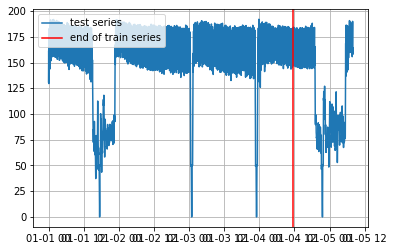

In [12]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
entry = next(iter(test_ds))
test_series = to_pandas(entry)
#test_series.plot()
plt.plot(test_series.index, test_series.values)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [13]:
#[np.sum(x['target'] == np.nan) for x in test_set]
[x['target'].shape for x in test_set]

[(6240,),
 (6140,),
 (6040,),
 (5940,),
 (5840,),
 (5740,),
 (5640,),
 (5540,),
 (5440,),
 (5340,),
 (5240,),
 (6256,),
 (6156,),
 (6056,),
 (5956,),
 (5856,),
 (5756,),
 (5656,),
 (5556,),
 (5456,),
 (5356,),
 (5256,),
 (6243,),
 (6143,),
 (6043,),
 (5943,),
 (5843,),
 (5743,),
 (5643,),
 (5543,),
 (5443,),
 (5343,),
 (5243,),
 (6244,),
 (6144,),
 (6044,),
 (5944,),
 (5844,),
 (5744,),
 (5644,),
 (5544,),
 (5444,),
 (5344,),
 (5244,),
 (5693,),
 (5593,),
 (5493,),
 (5393,),
 (5293,),
 (6250,),
 (6150,),
 (6050,),
 (5950,),
 (5850,),
 (5750,),
 (5650,),
 (5550,),
 (5450,),
 (5350,),
 (5250,),
 (6250,),
 (6150,),
 (6050,),
 (5950,),
 (5850,),
 (5750,),
 (5650,),
 (5550,),
 (5450,),
 (5350,),
 (5250,),
 (6251,),
 (6151,),
 (6051,),
 (5951,),
 (5851,),
 (5751,),
 (5651,),
 (5551,),
 (5451,),
 (5351,),
 (5251,),
 (6249,),
 (6149,),
 (6049,),
 (5949,),
 (5849,),
 (5749,),
 (5649,),
 (5549,),
 (5449,),
 (5349,),
 (5249,),
 (6252,),
 (6152,),
 (6052,),
 (5952,),
 (5852,),
 (5752,),
 (5652,),


In [14]:
train_series.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:01:00',
               '2019-01-01 00:02:00', '2019-01-01 00:03:00',
               '2019-01-01 00:04:00', '2019-01-01 00:05:00',
               '2019-01-01 00:06:00', '2019-01-01 00:07:00',
               '2019-01-01 00:08:00', '2019-01-01 00:09:00',
               ...
               '2019-01-04 11:14:00', '2019-01-04 11:15:00',
               '2019-01-04 11:16:00', '2019-01-04 11:17:00',
               '2019-01-04 11:18:00', '2019-01-04 11:19:00',
               '2019-01-04 11:20:00', '2019-01-04 11:21:00',
               '2019-01-04 11:22:00', '2019-01-04 11:23:00'],
              dtype='datetime64[ns]', length=5004, freq='T')

### validate the dataset

In [15]:
#1. Pocono lots of nan, why?
eventstr = 'Pocono'
telemetry_data = [telemetry_data_indy[events_id[eventstr]].copy()]
train_ds, test_ds, train_set, test_set = make_dataset_interpolate(prediction_length,'1min')                  

====event:Pocono, train_len=7560, max_len=9451, min_len=3
carno:1, totallen:9445, nancount:6719, skip
carno:4, totallen:9437, nancount:6455, skip
a short ts: carid=5，len=570
a short ts: carid=6，len=570
carno:9, totallen:9450, nancount:6277, skip
carno:10, totallen:9438, nancount:6301, skip
carno:12, totallen:9413, nancount:6845, skip
a short ts: carid=14，len=1847
carno:15, totallen:9439, nancount:6933, skip
carno:18, totallen:9451, nancount:6444, skip
a short ts: carid=19，len=572
carno:20, totallen:9415, nancount:6633, skip
a short ts: carid=21，len=1943
carno:22, totallen:9449, nancount:6544, skip
a short ts: carid=23，len=1
carno:26, totallen:9446, nancount:6127, skip
carno:27, totallen:9409, nancount:6616, skip
a short ts: carid=28，len=570
a short ts: carid=30，len=571
carno:59, totallen:9426, nancount:6119, skip
carno:88, totallen:7924, nancount:6718, skip
carno:98, totallen:9447, nancount:6621, skip


In [16]:
car1 = telemetry_data[0][2][0]


In [17]:
car1[:,2]

array([137.86, 149.22, 156.97, ..., 195.99, 195.18, 197.6 ])

In [18]:
nans, x= nan_helper(car1[:,2])
nan_count = np.sum(nans)
nan_count

6719

In [19]:
nans

array([False, False, False, ..., False, False, False])

In [20]:
len(nans)

9445

In [21]:
a = (car1[:,2]==np.nan)
a

array([False, False, False, ..., False, False, False])

In [22]:
np.sum(a)

0

In [23]:
b = np.isnan(car1[:,2])
for idx in range(len(b)):
    if b[idx]:
        print(idx, b[idx])
        break

814 True


In [24]:
car1[814:840,2]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])